# Visualization and Understanding
- Imagenet data로 학습된 CNN model을 불러와 학습된 kernel과 activation을 살펴봅니다.
- Grad-CAM을 통해 classification에 기여한 영상의 pixel들을 대략적으로 추측해봅니다.
- 아래 monai의 tutorial을 추가로 실습해봅니다.
  - https://github.com/Project-MONAI/tutorials/blob/master/modules/interpretability/class_lung_lesion.ipynb
  - https://github.com/Project-MONAI/tutorials/blob/master/modules/interpretability/covid_classification.ipynb


In [1]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import requests
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install pytorch-gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

     |████████████████████████████████| 6.0 MB 19.5 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=018764ae032fc9cd49dbe67a6aeca0769d9a0206d22ec044992999d82455606e
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [3]:
idx2label = pd.read_csv('https://raw.githubusercontent.com/hufsbme/T10402101/master/ch7_modern_ConvNets/imagenet_class_index.csv')
idx2label = idx2label.to_numpy()
idx2label = idx2label[:,1]

## Download pre-trained model from torch hub
https://pytorch.org/hub/ 

In [4]:
net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
net.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

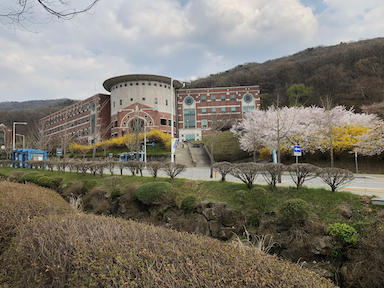

In [5]:
# sample execution (requires torchvision)

# web image
url  = 'https://raw.githubusercontent.com/hufsbme/T10402101/master/ch7_modern_ConvNets/hufs_campus.png'

#url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
input_image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# google drive image
#url  = '/content/drive/My Drive/hufs/image/hufs_campus.png'
#input_image = Image.open(url).convert("RGB")

input_image

In [6]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
output = net(input_batch)
output = torch.nn.functional.softmax(output[0], dim=0)
out_sort_val, out_sort_ind = output.sort()

1st prediction:  palace 	 with probability:  0.5019106 

2nd prediction:  castle 	 with probability:  0.37773496 

3rd prediction:  monastery 	 with probability:  0.036169283 

4th prediction:  lakeside 	 with probability:  0.010952359 

5th prediction:  mosque 	 with probability:  0.007952497 



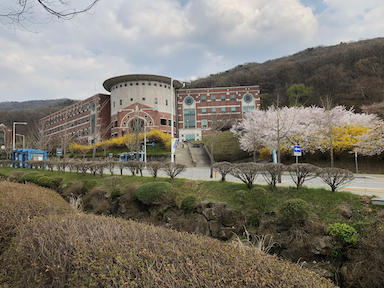

In [7]:
# top-5 predictions
print('1st prediction: ',idx2label[out_sort_ind[-1]],'\t with probability: ', out_sort_val[-1].detach().numpy(),'\n')
print('2nd prediction: ',idx2label[out_sort_ind[-2]],'\t with probability: ', out_sort_val[-2].detach().numpy(),'\n')
print('3rd prediction: ',idx2label[out_sort_ind[-3]],'\t with probability: ', out_sort_val[-3].detach().numpy(),'\n')
print('4th prediction: ',idx2label[out_sort_ind[-4]],'\t with probability: ', out_sort_val[-4].detach().numpy(),'\n')
print('5th prediction: ',idx2label[out_sort_ind[-5]],'\t with probability: ', out_sort_val[-5].detach().numpy(),'\n')

input_image

In [8]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Visualize filters (convolution kernels)

In [9]:
net.layer2[0].bn1

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [10]:
filters = net.conv1.weight.data.clone()
filters.shape

torch.Size([64, 3, 7, 7])

In [11]:
filters[2,2]

tensor([[ 0.0200, -0.0061, -0.0366, -0.0858,  0.0026,  0.0978, -0.0662],
        [ 0.0173,  0.0375,  0.1040,  0.0805, -0.3000, -0.1062,  0.1877],
        [-0.0060, -0.0106, -0.1153,  0.2167,  0.4017, -0.2864, -0.1643],
        [-0.0348,  0.0508,  0.0297, -0.3736,  0.1088,  0.4485, -0.0841],
        [ 0.0109, -0.0844,  0.1238,  0.1902, -0.3678, -0.1120,  0.1584],
        [ 0.0113,  0.0140, -0.1621,  0.0756,  0.2205, -0.0845, -0.0137],
        [-0.0069,  0.0092,  0.0374, -0.1104, -0.0536,  0.0397, -0.0018]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


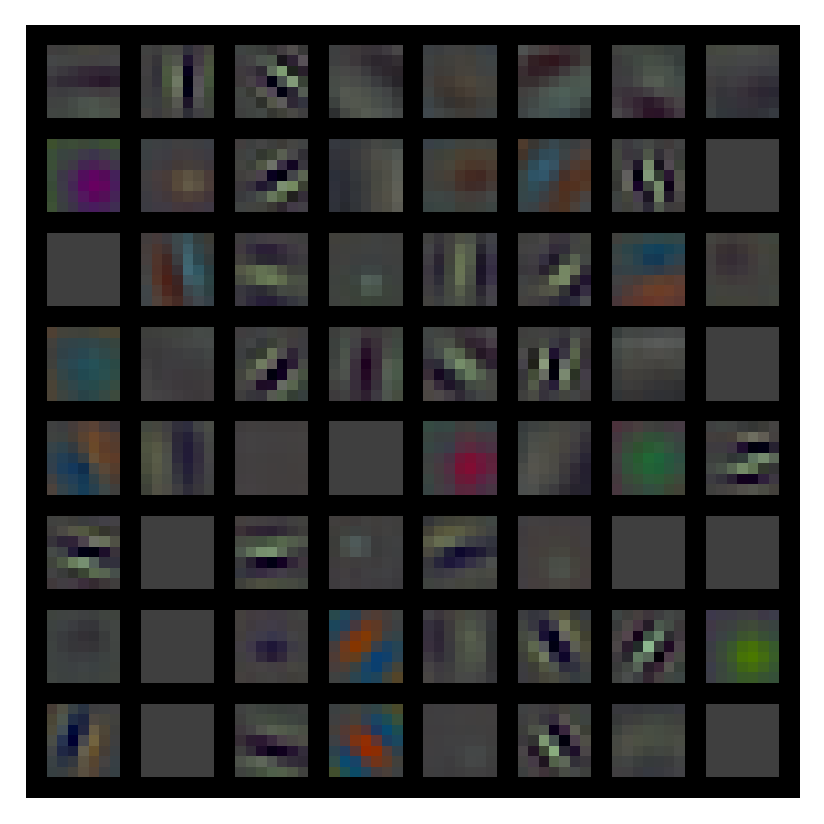

In [12]:
plt.figure(dpi=256)
plt.imshow(np.transpose(make_grid(filters+.5,8)*.5,[1,2,0]))
plt.axis('off')
plt.show()

## Get hidden layer outputs

In [13]:
#net_ = nn.Sequential(*list(net.children())[0])
net_ = nn.Sequential(*list(net.children())[:4])
#net_ = nn.Sequential(net.features,net.avgpool,net.classifier[:5])
for param in net_.parameters():
    param.requires_grad = False
net_

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [14]:
out_ = net_(input_batch)
out__=out_[0].unsqueeze(dim=1)
out__.shape

torch.Size([64, 1, 56, 56])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 465.5, 465.5, -0.5)

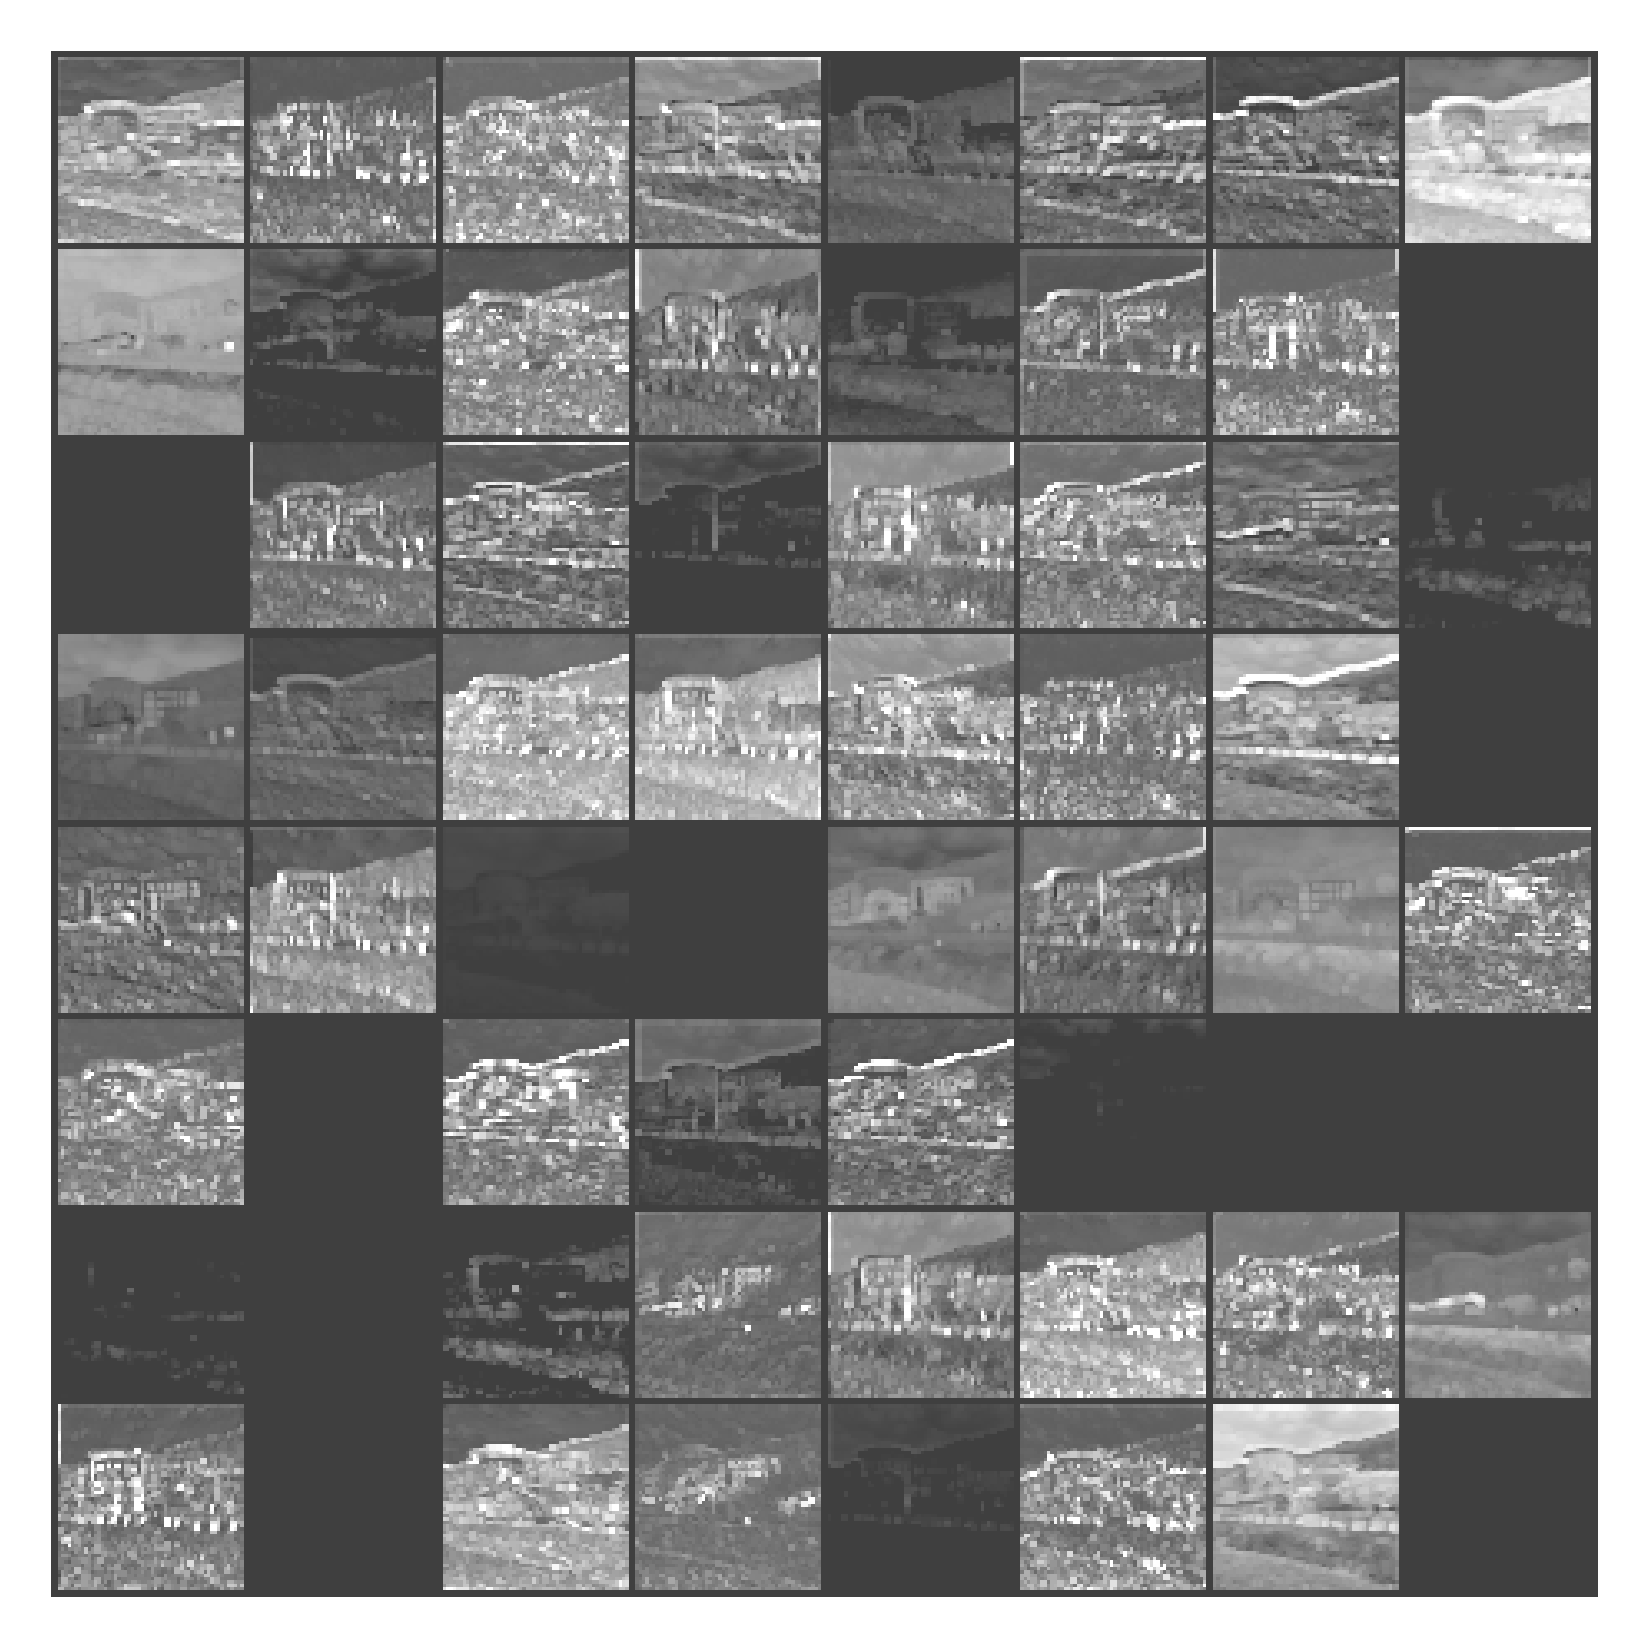

In [15]:
out__=make_grid(out__,8)
plt.figure(dpi=512)
plt.imshow(np.transpose((out__+.5)*.5,[1,2,0]))
plt.axis('off')

## Grad CAM
https://github.com/vickyliin/gradcam_plus_plus-pytorch


In [16]:
gradcam = GradCAM(net, net.layer4)
mask, _ = gradcam(input_batch)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


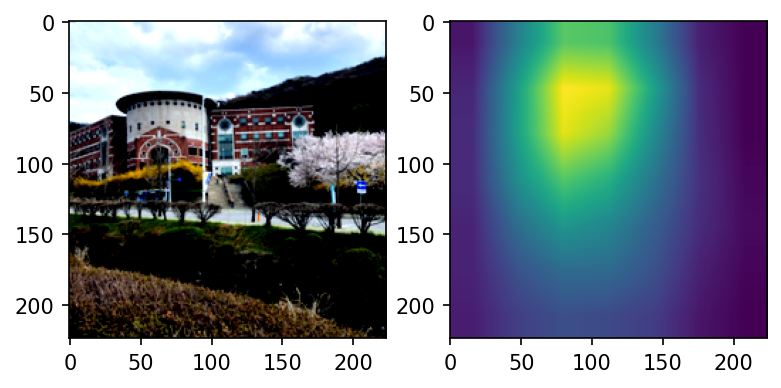

In [18]:
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(np.transpose((input_tensor+0.5)*.5,[1,2,0]))
plt.subplot(122)
plt.imshow(np.transpose(np.squeeze(mask)))